# Visibilities
An overview of the visibility data structure and manipulation.

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/visibilities.ipynb)

In [5]:
# TEMPORARY WORKAROUND for Python 3.7 - you must run this notebook twice!!
import os
import numpy as np

if np.__version__ != '1.20.1':
    print('updating numpy and killing runtime....\nPlease re-run this notebook (Runtime -> Run all)')
    os.system('pip install --upgrade numpy==1.20.1')
    os._exit(00)

In [6]:
# Installation  
import os
print("installing casa6 + cngi (takes a minute or two)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatasks==6.2.0.96")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casadata")
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.73rc2")

# Retrieve and extract demonstration dataset
print('retrieving MS tarfile...')
!gdown -q --id 1N9QSs2Hbhi-BrEHx5PA54WigXt8GGgx1
print('extracting MS tarfile...')
!tar -xzf sis14_twhya_calibrated_flagged.ms.tar.gz

print('complete')

installing casa6 + cngi (takes a minute or two)...
retrieving MS tarfile...
extracting MS tarfile...
complete


## Initialize the Environment
`InitializeFramework` instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

```python
>>> from cngi.direct import InitializeFramework
>>> client = InitializeFramework(workers=4, memory='2GB')
>>> print(client)
<Client: 'tcp://127.0.0.1:33227' processes=4 threads=4, memory=8.00 GB>
```

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well, so we will let Dask use its default scheduler.


## MeasurementSet Conversion
CNGI uses an [xarray](http://xarray.pydata.org/en/stable/data-structures.html#dataset) dataset and the zarr storage format to hold the contents of the MS.  This provides several advantages to the old MS structure including:
1. Easier access and manipulation of data with numpy-like mathematics
2. N-dim visibility cubes (time, baseline, chan, pol) instead of interlaced rows of variable shape
3. Natively parallel and scalable operations


In [1]:
from cngi.conversion import convert_ms

mxds = convert_ms('sis14_twhya_calibrated_flagged.ms', outfile='twhya.vis.zarr')

Completed ddi 0  process time 10.11 smaining time est 0 s                           
Completed subtables  process time 0.68 sSTATION_POSITION...                     
                                                  


The visibility xarray dataset (xds) structure has four main components:

**Dimensions** define the shape of the other components, and allow indexing into other components by integer location within each dimension (ie channel 5). Note that dimensions may be printed alphabetically by Jupyter, with the actual order being different in the data itself. Referring to a dimension by its name eliminates the need to remember what order things are in.

**Coordinates** define the world values of dimensions and other indices within the dataset. This allows indexing into other components by actual value (ie channel 100 GHz). Note that in many cases the real world value is itself just an integer index (ie the baseline), but time and channel frequency are particularly useful.

**Data variables** are the columns of the main table. They typically have the same data type and meaning as defined in the MSv3 schema. They are stored as Dask arrays which allow numpy-like operations that are parallel, scalable, and support larger than memory data sizes. Nan values are used to pad and flag areas with no valid data, and consequently all mathematics must be smart enough to properly ignore Nans in computations.

**Attributes** are used to hold units, reference frames, and any other metadata associated with the dataset. They can be any python type or object when in memory, but only serializable types may be written to disk.

Each xds comes from a separate zarr partition, and corresponds to a particular spw and polarization combination (as denoted by coordinate values).  Here we can see another of the four xds paritions from the previous conversion of the demonstration MS

In [2]:
print(mxds.xds0)

<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 384, pol: 2, pol_id: 1, spw_id: 1, time: 410, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width      (chan) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(32,), meta=np.ndarray>
  * pol             (pol) int64 9 12
  * pol_id          (pol_id) int64 0
    resolution      (chan) float64 dask.array<chunksize=(32,), meta=np.ndarray>
  * spw_id          (spw_id) int64 0
  * time            (time) datetime64[ns] 2012-11-19T07:37:00 ... 2012-11-19T...
Dimensions without coordinates: uvw_index
Data variables:
    ANTENNA1        (baseline) int64 dask.array<chunksize=(210,), meta=np.ndarray>
    ANTENNA2        (baseline) int64 dask.array<chunksize=(210,), meta=np.ndarray>
    ARRAY_ID        (time, baseline) int64 dask.array<

## Simple Plotting

We can quickly spot check data fields using ```visplot```. This is handy during subsequent analysis (although not intended for full scientific analysis).

The visplot function supports both standard x-y plots and x-y-c color mesh visualization.  The mode is determined by the number of dimensions in the data passed in

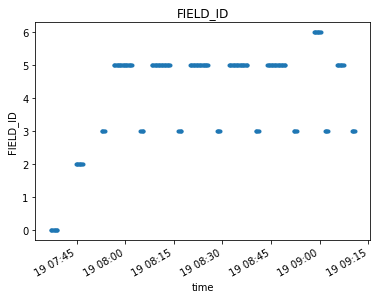

In [3]:
from cngi.dio import read_vis
from cngi.vis import visplot

# open a visibility xds
xds = read_vis('twhya.vis.zarr').xds0

# fields versus time coordinate
visplot(xds.FIELD_ID, axis='time')

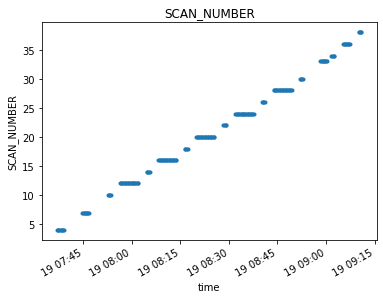

In [4]:
visplot(xds.SCAN_NUMBER, 'time')

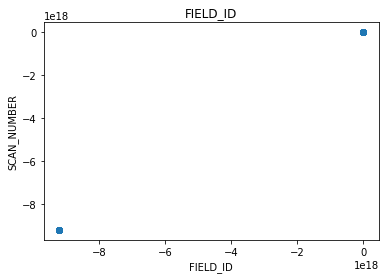

In [5]:
# 2-D plot - fields versus scans
visplot(xds.FIELD_ID, xds.SCAN_NUMBER)

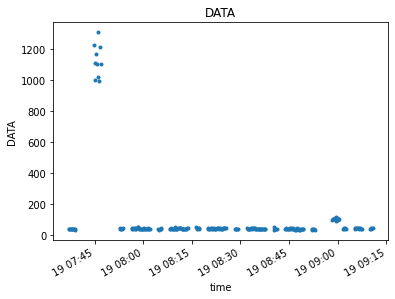

In [6]:
# 2-D plot of 4-D data - DATA over time
# when we specify an x-axis (time), the other axes (baseline, chan, pol) are averaged together
visplot(xds.DATA, axis='time')

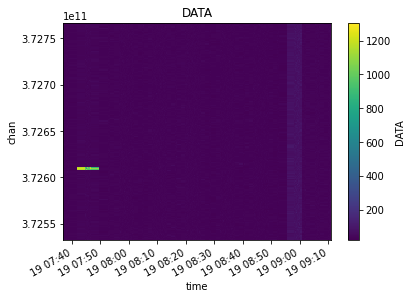

In [7]:
# 3-D plot of 4-D data - DATA over time and channel
# we can give two axes to create a color mesh visualization
visplot(xds.DATA, axis=['time','chan']) 

## Selection and Splitting

The xarray Dataset format has extensive built-in functions for selecting data and splitting by different criteria.  Often times the global data is referenced to identify particular values to select by.

Once the selection values are known, ```xds.isel(...)``` and ```xds.sel(...)``` can be used to select by dimension index or world value. ```xds.where(...)``` can be used to select by anything.  

Lets start by examining the range of time and channel frequency values we have available in the visibility xds along with the field names and state ids in the global data.

In [8]:
from cngi.dio import read_vis
import numpy as np

# open the master xds
mxds = read_vis('twhya.vis.zarr')

# inspect some properties
print('times: ', mxds.xds0.time.values[0], ' to ', mxds.xds0.time.values[-1])
print('chans: ', mxds.xds0.chan.values[0], ' to ', mxds.xds0.chan.values[-1])
print('fields: ', mxds.fields.values)

times:  2012-11-19T07:37:00.000000000  to  2012-11-19T09:11:01.631999969
chans:  372533086425.9812  to  372766851074.4187
fields:  ['J0522-364' 'J0539+145' 'Ceres' 'J1037-295' 'TW Hya' 'TW Hya' '3c279']


We can directly select specific dimension indices if we know what we're looking for

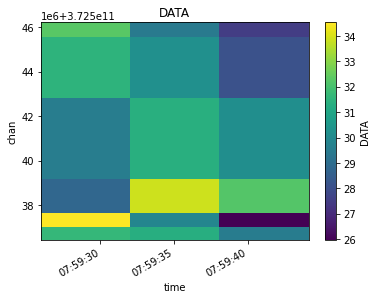

In [9]:
xds = mxds.xds0.isel(time=[76,77,78], chan=[6,7,8,12,20,21])

visplot(xds.DATA, ['time', 'chan'])

Or select by a range of dimension values, in this case lets select data between 372.59 and 372.63 GHz

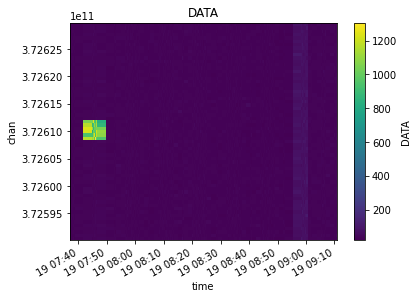

In [10]:
xds = mxds.xds0.sel(chan=slice(372.59e9, 372.63e9))

visplot(xds.DATA, ['time', 'chan'])

Or select by a particular field value, in this case lets select just the TW Hya fields

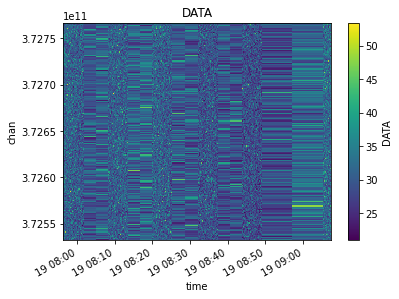

In [11]:
fields = mxds.field_ids[np.where(mxds.fields == 'TW Hya')].values

xds = mxds.xds0.where(mxds.xds0.FIELD_ID.isin(fields), drop=True)

visplot(xds.DATA, axis=['time','chan']) 

Finally, lets do a more complicated multi-selection

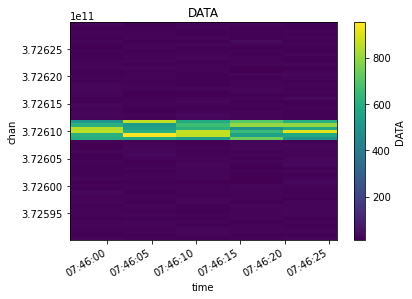

In [12]:
xds = mxds.xds0.where(mxds.xds0.ANTENNA1.isin([2,3,4,5]) & mxds.xds0.ANTENNA2.isin([2,3,4,5]) &
                       (mxds.xds0.chan > 372.59e9) & (mxds.xds0.chan < 372.63e9) & 
                       (mxds.xds0.time > np.datetime64('2012-11-19T07:45:50.0')) & 
                       (mxds.xds0.time < np.datetime64('2012-11-19T07:46:30.0')), 
                       drop=True)

visplot(xds.DATA, ['time', 'chan'])

Rather than cluttering each CNGI function with many parameters for data selection, instead the Dataset should be appropriately split before calling the relevant CNGI API function(s).


Once you have the data selected that you want to work on, you can use split_dataset (was mstransform) to split that data out into its own mxds. The new mxds will include only the selected visibility and subtable data.

In [13]:
from cngi.vis import split_dataset

# slice and split out the new mxds
xds_slice = mxds.xds0.sel(chan=slice(372.59e9, 372.63e9))
mxds_slice = mxds.assign_attrs(xds0=xds_slice) # replace xds0
mxds_slice = split_dataset(mxds_slice, 'xds0')

# we should now have a new mxds with less data, which we can see with a few print statements
print("Select a subset of channels. Unrelated data (such as antennas) to the remaining channels are dropped.")
print(f"old mxds: {len(mxds.xds0.chan)} chans, {len(mxds.antenna_ids)} antennas")
print(f"new mxds: {len(mxds_slice.xds0.chan)} chans, {len(mxds_slice.antenna_ids)} antennas")

Select a subset of channels. Unrelated data (such as antennas) to the remaining channels are dropped.
old mxds: 384 chans, 26 antennas
new mxds: 65 chans, 21 antennas


## Joining

A split mxds, or several mxds gathered from different telescopes are times, can be merged back into a single mxds for further calibration or computation with join_dataset (was concat).

In [14]:
from cngi.dio import read_vis
from cngi.vis import join_dataset
import numpy as np

# open the master xds
mxds = read_vis('twhya.vis.zarr')

# split out several channels to run computations on
mxds_slice0 = mxds.assign_attrs(xds0=mxds.xds0.sel(chan=slice(372.57e9, 372.60e9)))
mxds_slice1 = mxds.assign_attrs(xds0=mxds.xds0.sel(chan=slice(372.67e9, 372.70e9)))
# do channel-dependent operations...

# merge the split mxds into a single mxds (takes some time)
tmp_mxds = join_dataset(mxds_slice0, mxds_slice1) # mxds_slice1.xds0 is moved to mxds_cal.xds1
list(filter(lambda n: 'xds' in n, tmp_mxds.attrs.keys()))

['xds0', 'xds1']

Similarly, visibilities can be merged with join_vis. Think really hard about when it is appropriate to use this function, however, since some meaning inherent to the data could be lost by doing further computation on the merged dataset.

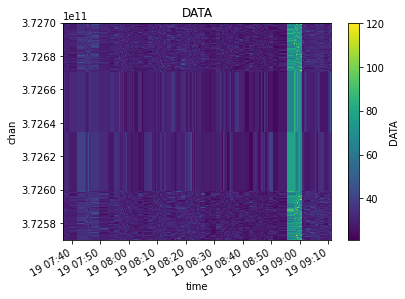

In [15]:
from cngi.vis import join_vis
from cngi.vis import visplot

# merge the slices back together
mxds_joined = join_vis(tmp_mxds, 'xds0', 'xds1')
visplot(mxds_joined.xds0.DATA, ['time', 'chan'])

# compare to the extra data in channels 372.60-372.62 which outshines everything
# xds_compare = mxds.xds0.sel(chan=slice(372.57e9, 372.70e9))
# visplot(xds_compare.DATA, ['time', 'chan'])

## Flagging

Any boolean data variable can be used to flag any other data variable of common dimension(s).

Flagged values are set to np.nan, and subsequent math/analysis should be of the type that ignores nan values.

First lets see the original raw data

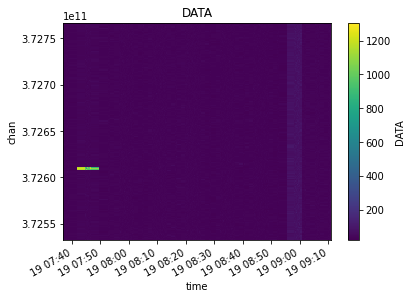

In [16]:
from cngi.dio import read_vis

mxds = read_vis('twhya.vis.zarr')

visplot(mxds.xds0.DATA, ['time', 'chan'])

Now lets flag the entire dataset contents based on the value of the FLAG data variable.  The bright line from Ceres is replaced with Nan's (that appear as blank whitespace in the plot)

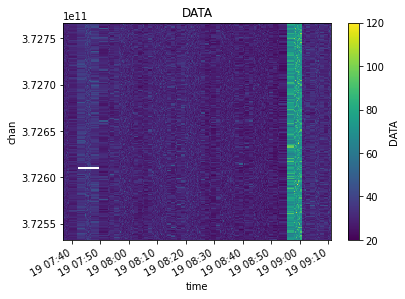

In [17]:
from cngi.vis import apply_flags

flagged_xds = apply_flags(mxds, 'xds0', flags='FLAG')

visplot(flagged_xds.xds0.DATA, ['time', 'chan'])

## Averaging and Smoothing
Averaging functions will change the shape of the resulting xarray dataset along the dimension being averaged.  

Smoothing functions always return an xarray dataset with the same dimensions as the original.

We will use the TWHya dataset for this section. Dask may emit performance warnings if the chunk size is too small. We can increase our chunk size in the xds to any multiple of the chunk size used during conversion. We will do that here to avoid the performance warnings for this section. Note that baseline is already chunked at the maximum for its dimension size, so we can omit it.

In [18]:
from cngi.dio import read_vis

mxds = read_vis('twhya.vis.zarr', chunks=({'time':200, 'chan':64, 'pol':2}))

### Channel Averaging

The channel averaging function looks for all data variables in the dataset with a channel dimension and averages by the specified bin width.  The returned dataset will have a different channel dimension size.

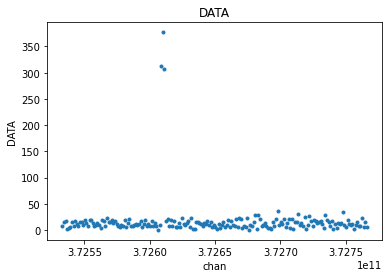

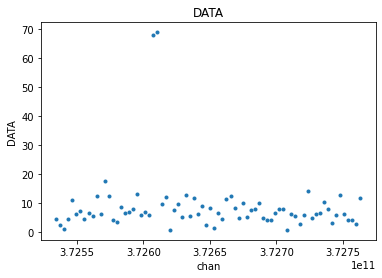

In [19]:
from cngi.vis import chan_average, visplot

# average 5 channels of original unflagged data
avg_xds = chan_average(mxds, 'xds0', width=5)

# compare the original to the channel averaged
visplot(mxds.xds0.DATA[30,0,:,0], 'chan')
visplot(avg_xds.xds0.DATA[30,0,:,0], 'chan')

In [20]:
# confirm new channel dimension after averaging
print(dict(mxds.xds0.dims))
print(dict(avg_xds.xds0.dims))

{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 410, 'uvw_index': 3}
{'baseline': 210, 'chan': 76, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 410, 'uvw_index': 3}


Since every variable with a channel dimension in the dataset is averaged, this will also include the FLAG variable.  FLAG is a boolean type with values of 0 or 1 that are averaged over the width, resulting in a decimal number.  The result is then typcast back to boolean, which is the same as just rounding up.

Long story short, if any channel in the width is flagged, the resulting averaged channel will also be flagged

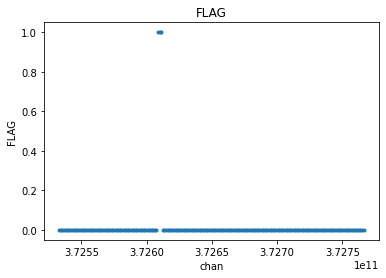

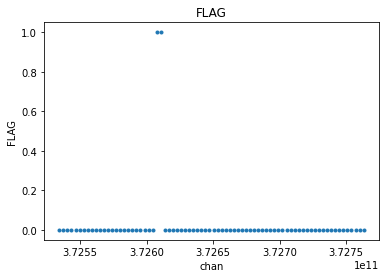

In [21]:
# compare the original flags to the channel averaged flags
visplot(mxds.xds0.FLAG[30,0,:,0], 'chan')
visplot(avg_xds.xds0.FLAG[30,0,:,0], 'chan')

One might want to apply flags before channel averaging

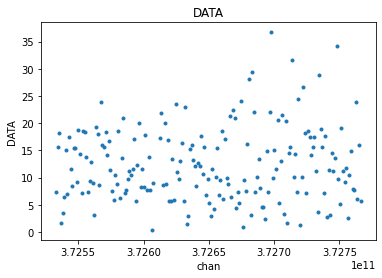

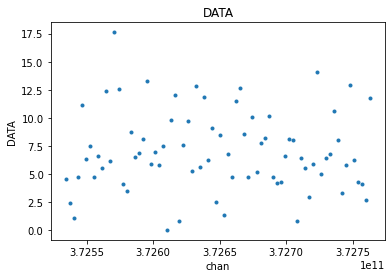

In [22]:
from cngi.vis import apply_flags

flg_xds = apply_flags(mxds, 'xds0', flags=['FLAG'])
avg_flg_xds = chan_average(flg_xds, 'xds0', width=5)

visplot(flg_xds.xds0.DATA[30,0,:,0], 'chan')
visplot(avg_flg_xds.xds0.DATA[30,0,:,0], 'chan')

Or apply flags after channel averaging

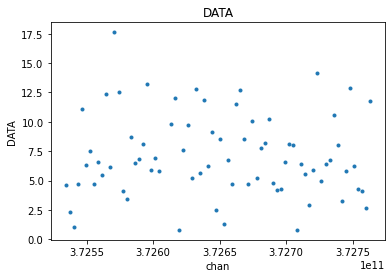

In [23]:
flg_avg_xds = apply_flags(avg_xds, 'xds0', flags=['FLAG'])

visplot(flg_avg_xds.xds0.DATA[30,0,:,0], 'chan')

There is a small difference of two points, made more clear when we overlay the plots

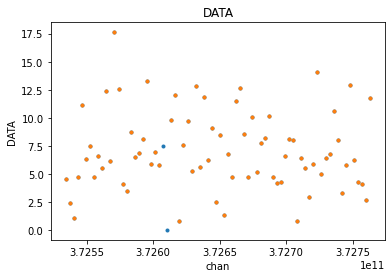

In [24]:
visplot(avg_flg_xds.xds0.DATA[30,0,:,0], 'chan', drawplot=False)
visplot(flg_avg_xds.xds0.DATA[30,0,:,0], 'chan', overplot=True)

### Time Averaging

The time averaging function can combine adjacent time steps or resample to a new uniform time step. This affects all fields in the xds that have a time dimension. The span parameter can be used to limit averaging to just the time steps within each scan, or within each state. The returned dataset will have a different time dimension size.

First let's average across the states in a scan using a bin of 7

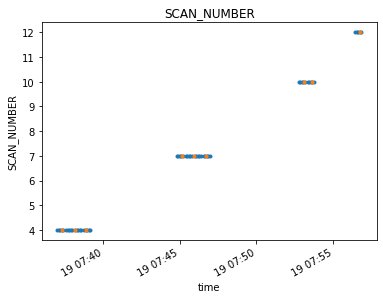

In [25]:
from cngi.vis import time_average

state_xds = time_average(mxds,'xds0', bin=7, span='state')

visplot(mxds.xds0.SCAN_NUMBER.where(mxds.xds0.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', drawplot=False)
visplot(state_xds.xds0.SCAN_NUMBER.where(state_xds.xds0.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', overplot=True)

Averaging across both state and scan allows the bins to cross the time gaps between scans.

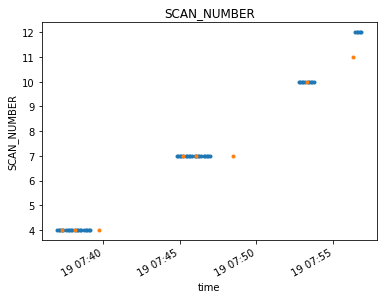

In [26]:
both_xds = time_average(mxds, 'xds0', bin=7, span='both')

visplot(mxds.xds0.SCAN_NUMBER.where(mxds.xds0.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', drawplot=False)
visplot(both_xds.xds0.SCAN_NUMBER.where(both_xds.xds0.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', overplot=True)

Switching to the width parameter will resample the contents of the xds to a uniform time bin across the span

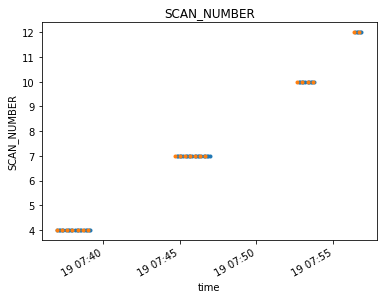

In [27]:
resampled_xds = time_average(mxds, 'xds0', width='20s', span='state')

visplot(mxds.xds0.SCAN_NUMBER.where(mxds.xds0.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', drawplot=False)
visplot(resampled_xds.xds0.SCAN_NUMBER.where(resampled_xds.xds0.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', overplot=True)

In all cases, the dimensionality of the time averaged xds returned will be different than the start.

In [28]:
print(dict(mxds.xds0.dims))
print(dict(state_xds.xds0.dims))
print(dict(both_xds.xds0.dims))
print(dict(resampled_xds.xds0.dims))

{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 410, 'uvw_index': 3}
{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 68, 'uvw_index': 3}
{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 59, 'uvw_index': 3}
{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 150, 'uvw_index': 3}


We can inspect the affect of different time averaging methods on the DATA contents

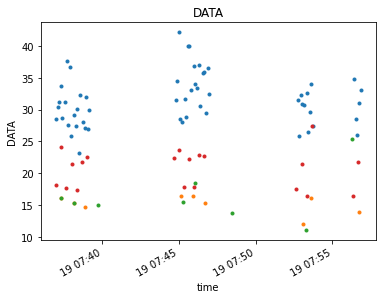

In [29]:
timefilter = np.datetime64('2012-11-19T07:57:00.0')
visplot(mxds.xds0.DATA.where(mxds.xds0.time < timefilter, drop=True)[:,:,100,0], 'time', drawplot=False)
visplot(state_xds.xds0.DATA.where(state_xds.xds0.time < timefilter, drop=True)[:,:,100,0], 'time', overplot=True, drawplot=False)
visplot(both_xds.xds0.DATA.where(both_xds.xds0.time < timefilter, drop=True)[:,:,100,0], 'time', overplot=True, drawplot=False)
visplot(resampled_xds.xds0.DATA.where(resampled_xds.xds0.time < timefilter, drop=True)[:,:,100,0], 'time', overplot=True)

Flagging works the same way as in channel averaging.  Flags are averaged with all other data sharing the time axis.  They may be applied before or after time averaging. The time averaged flag field is converted back to boolean.  Any single flagged value in the original data will cause the entire bin to be flagged in the resulting data.

### Channel Smoothing

Channel smoothing allows a variety of window shapes to be convolved across the channel dimension to smooth over changes from bin to bin. The standard CASA hanning smooth is supported as the default option.  The returned dataset will have the same dimensions as the original.

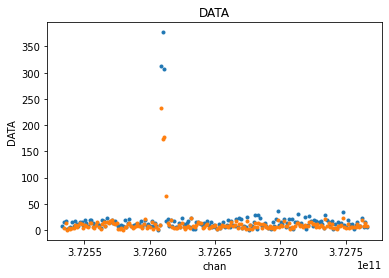

In [30]:
from cngi.vis import chan_smooth

smooth_xds = chan_smooth(mxds, 'xds0')

visplot(mxds.xds0.DATA[30,0,:,0], 'chan', drawplot=False)
visplot(smooth_xds.xds0.DATA[30,0,:,0], 'chan', overplot=True)

chansmooth uses the scipy.signal package to set the window shape. Therefore, all the window functions supported by scipy are also supported here.  The size of the window width is configurable.

[https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows)


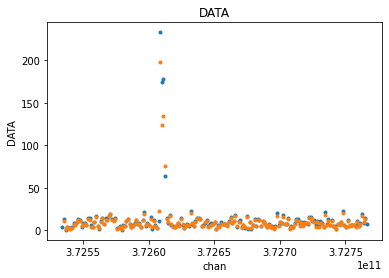

In [31]:
bohman_xds = chan_smooth(mxds, 'xds0', type='bohman', size=7)

visplot(smooth_xds.xds0.DATA[30,0,:,0], 'chan', drawplot=False)
visplot(bohman_xds.xds0.DATA[30,0,:,0], 'chan', overplot=True)

non-unity gains are also supported to amplify or attenuate the output

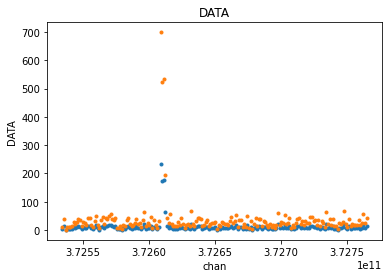

In [32]:
hann_xds = chan_smooth(mxds, 'xds0', type='hann', size=5, gain=1.0)
amp_hann_xds = chan_smooth(mxds, 'xds0', type='hann', size=5, gain=3.0)

visplot(hann_xds.xds0.DATA[30,0,:,0], 'chan', drawplot=False)
visplot(amp_hann_xds.xds0.DATA[30,0,:,0], 'chan', overplot=True)

## UV Fitting

Various modeling can be performed in the UV-domain through polynomial regression on the visibility data.

The uvcontfit function takes a source data variable in the xarray dataset and fits a polynomial of fitorder across the channel axis.  The resulting model is placed in the target data variable and retains the dimensionality of the source. Specified channels may be excluded to focus on fitting only continuum visibilities and not line emissions.

In our example dataset we know that the Ceres has a line emission, so let's focus on just that field.  We will need to master xarray dataset to see which field ID(s) is Ceres.

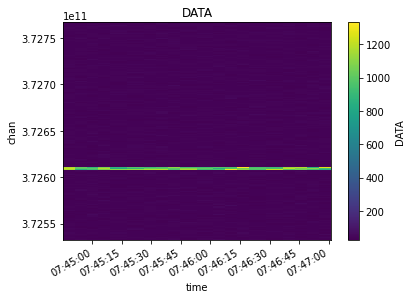

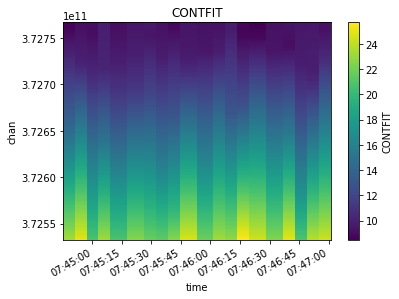

In [33]:
from cngi.dio import read_vis
from cngi.vis import uv_cont_fit, visplot
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

mxds = read_vis('twhya.vis.zarr')

fields = mxds.field_ids[np.where(mxds.fields == 'Ceres')].values

mxds = mxds.assign_attrs({'ceres_xds':mxds.xds0.where(mxds.xds0.FIELD_ID.isin(fields), drop=True)})

fit_xds = uv_cont_fit(mxds, 'ceres_xds', source='DATA', target='CONTFIT')

visplot(fit_xds.ceres_xds.DATA, ['time', 'chan'])
visplot(fit_xds.ceres_xds.CONTFIT, ['time', 'chan'])

What we are seeing is merged across baselines and polarizations.  Let's look at just one time/baseline/pol sample and examine the fit.  The linear fit is skewed by the line emission towards one side of the channel axis.


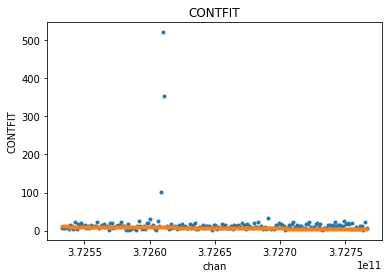

In [34]:
visplot(fit_xds.ceres_xds.DATA[10,10,:,0], ['chan'], drawplot=False)
visplot(fit_xds.ceres_xds.CONTFIT[10,10,:,0], ['chan'], overplot=True)

Let's omit the channels with the line emission and do the fit again.  We should see less skewing in the fitted continuum.

The fits appear lower in value than the mean of the data when viewing the magnitude of complex visibilities. The real and imaginary parts are fitted individually. We examine just the real piece here to see a that the fit is indeed a decent approximation through the center of the data.

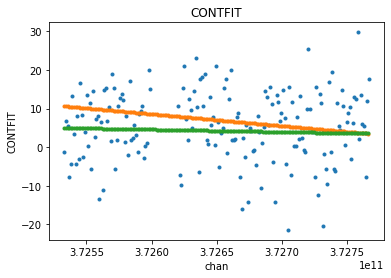

In [35]:
excludechans = np.where( (mxds.xds0.chan > 3.726e11) & (mxds.xds0.chan < 3.7262e11) )[0]

fit_xds2 = uv_cont_fit(mxds, 'ceres_xds', source='DATA', target='CONTFIT', fitorder=1, excludechans=excludechans)

includechans = np.setdiff1d( range(mxds.xds0.dims['chan']), excludechans)
visplot(fit_xds2.ceres_xds.DATA[10,10,includechans,0].real, ['chan'], drawplot=False)
visplot(fit_xds.ceres_xds.CONTFIT[10,10,:,0].real, ['chan'], drawplot=False, overplot=True)
visplot(fit_xds2.ceres_xds.CONTFIT[10,10,:,0].real, ['chan'], overplot=True)

For even more fun, we can try a higher order fit. Let's use all channels to allow the line emission to exaggerate the non-linearity, but only plot the continuum DATA channels so the y-scale stays smaller.

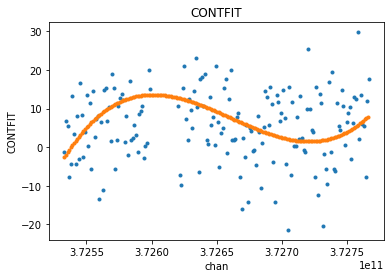

In [36]:
fit_xds3 = uv_cont_fit(mxds, 'ceres_xds', source='DATA', target='CONTFIT', fitorder=3, excludechans=[])

visplot(fit_xds3.ceres_xds.DATA[10,10,includechans,0].real, ['chan'], drawplot=False)
visplot(fit_xds3.ceres_xds.CONTFIT[10,10,:,0].real, ['chan'], overplot=True)

Several metrics related to the quality of the fit are stored in the xarray dataset attributes section as metadata.  They are named with a prefix matching the target parameter in uvcontfit.

In [37]:
metrics = [kk for kk in fit_xds.ceres_xds.attrs.keys() if kk.startswith('CONTFIT')]
print(metrics)

print(fit_xds.ceres_xds.CONTFIT_rms_error)

['CONTFIT_rms_error', 'CONTFIT_min_max_error', 'CONTFIT_bw_frac', 'CONTFIT_freq_frac']
<xarray.DataArray ()>
dask.array<pow, shape=(), dtype=complex128, chunksize=(), chunktype=numpy.ndarray>


One thing to note is that these metrics are dask elements, and are not actually computed until explicity requested. Things like visplot explicity force the computation of the data needed for plotting, but nothing has forced these metrics to be computed yet. So we will call .compute() to see their values.

In [38]:
print('rms error with line included: ', fit_xds.ceres_xds.CONTFIT_rms_error.values)
print('rms error with line excluded: ', fit_xds2.ceres_xds.CONTFIT_rms_error.values)

rms error with line included:  (16.444908051664182-0.7566763926282181j)
rms error with line excluded:  (0.37306136672597817-0.007993456030923675j)
